# Molecular ISDF Timings

## Running on the Remote

On MPSD:
```
tmux new -s jlab
source programs/isdfBenchmarks/.venv/bin/activate
jupyter lab --no-browser --ip=0.0.0.0 --port 8888
```

Detach with `Ctrl-b d`
Reattach with: `tmux attach -t jlab`
Paste the Jupyter URL into `Settings > Jupyter > Jupyter Servers > Configured servers`

## TODOs
* For `24_anthracene`, plot comparison of the timings as a function of the number of MPI processes



In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time


## Discussion of Timings

Original data: `results_root = Path("/home/bucchera/exchange_calcs/isdf")`
Current data: `results_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")`

Original Data:

* No distribution of Poisson solves, either in terms of using a distributed Poisson solver, or in terms of splitting the ISDF vectors (hence solves) across MPI ranks.

Current Data:

* Uses MPI to distribute the ISDF vectors, which distributes the number of Poisson solves. 
* ISDF is now faster than the existing reference for all but the smallest system (should check why this one is still slow)
* However, the speed-up only looks like a factor of two, despite using 4 MPI processes. I have to assume that I am losing 50% of the speed-up in communicating `np * (N_mu/n_processes)` worth of data from each process to all others 
    * Particularly as the calculation of the ISDF potential (Poisson solve, followed by comms) still takes MOST of the total ISDF time.


In [2]:
# Parse ISDF profiling times

results_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

isdf_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    isdf_results[dir] = {'cumulative': cumulative, 'self':self}


In [3]:
# Parse reference ACE profiling time

results_root = Path("/home/bucchera/exchange_calcs/reference_ace")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

ref_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    ref_results[dir] = {'cumulative': cumulative, 'self':self}
    

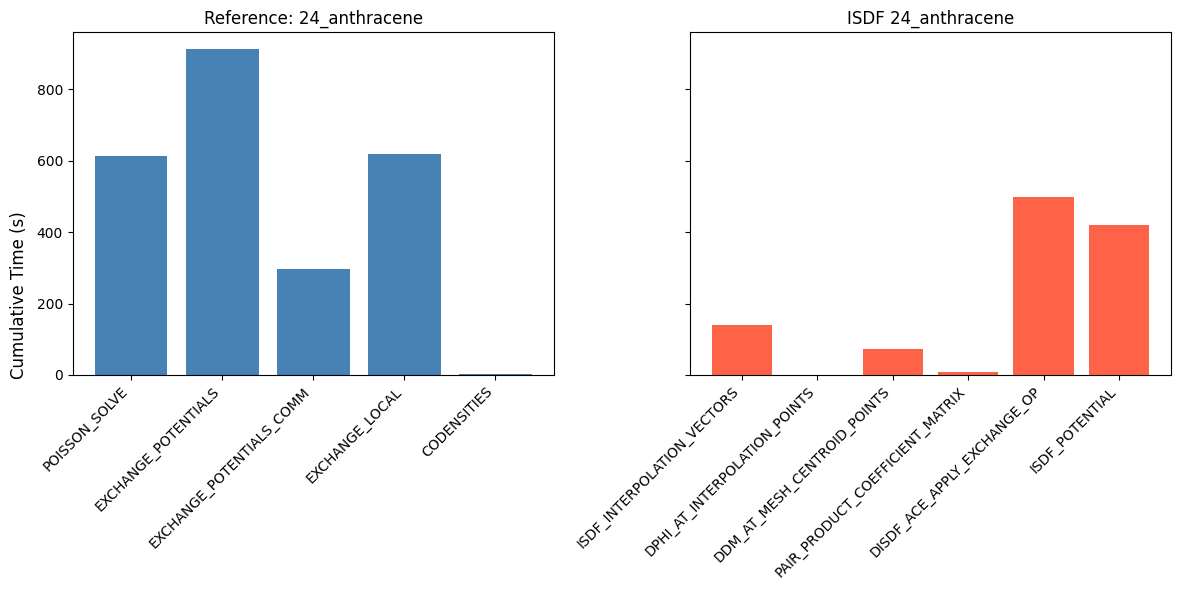

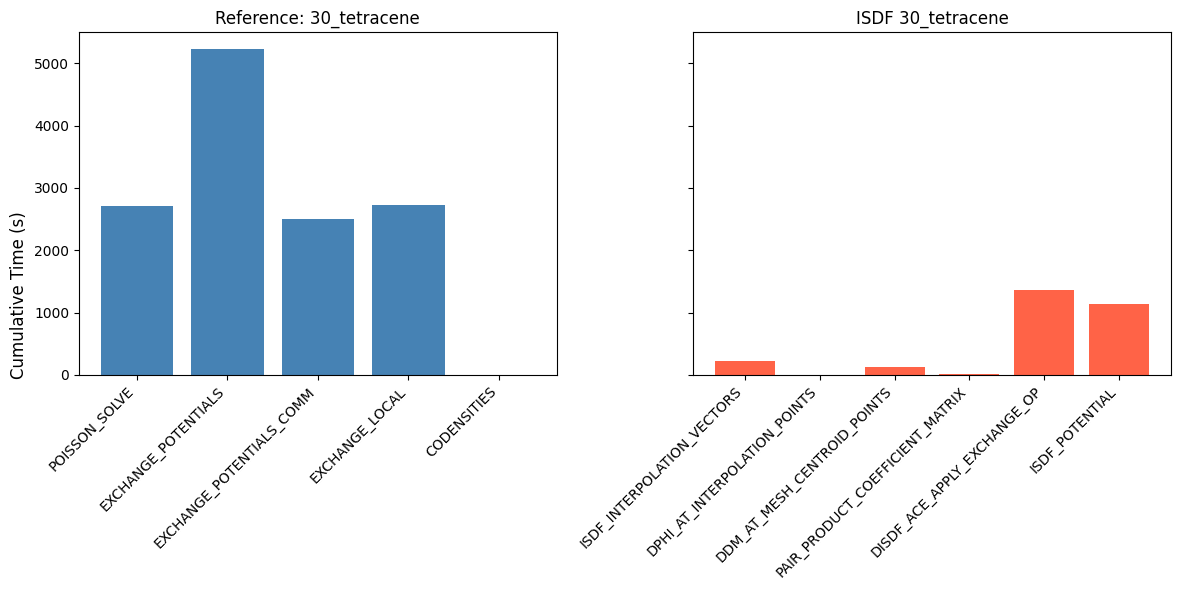

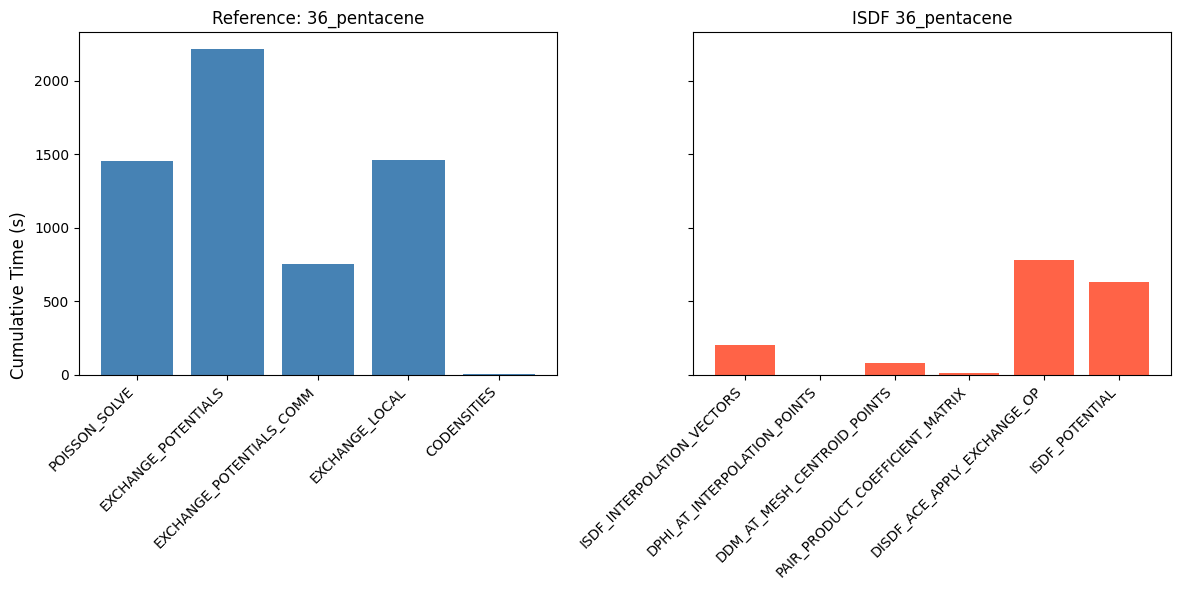

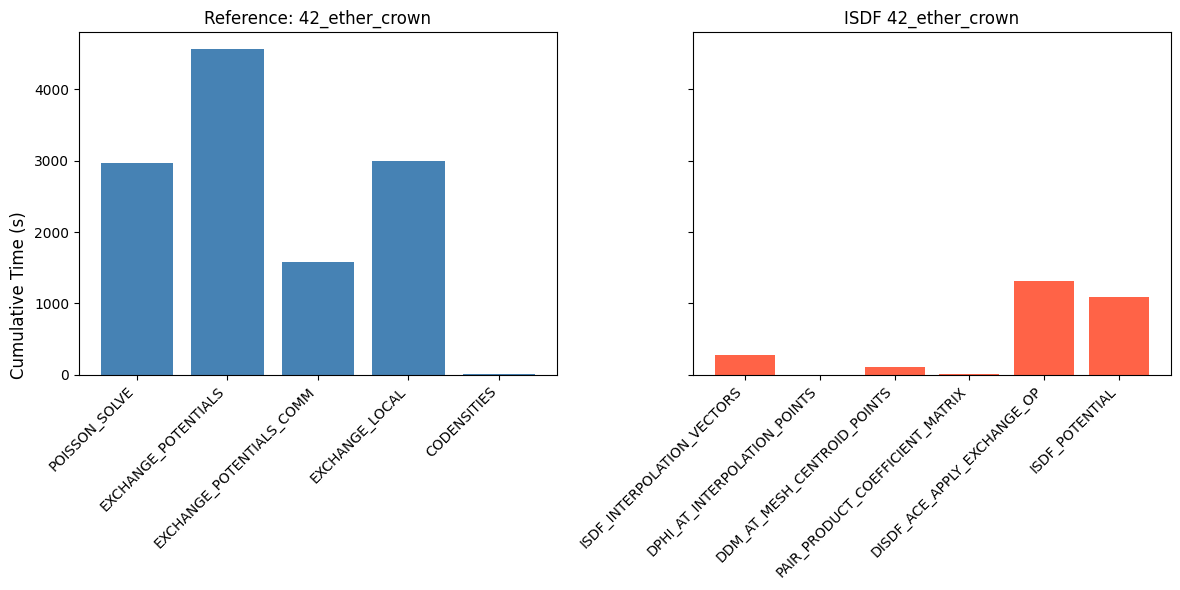

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Reference routines
ref_routines = ['POISSON_SOLVE', 
                'EXCHANGE_POTENTIALS', 
                'EXCHANGE_POTENTIALS_COMM', 
                'EXCHANGE_LOCAL', 
                'CODENSITIES']

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL']

# Plotting.
for dir in directories:
    fig, (ax_ref, ax_isdf) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    add_bars(ax_ref,  ref_routines,  to_total_time(ref_results[dir]['cumulative'], ref_routines),  color='steelblue')
    ax_ref.set_title(f'Reference: {dir}')
    
    add_bars(ax_isdf, isdf_routines, to_total_time(isdf_results[dir]['cumulative'], isdf_routines), color='tomato')
    ax_isdf.set_title(f'ISDF {dir}')
    
    fig.supylabel('Cumulative Time (s)')
    fig.tight_layout()


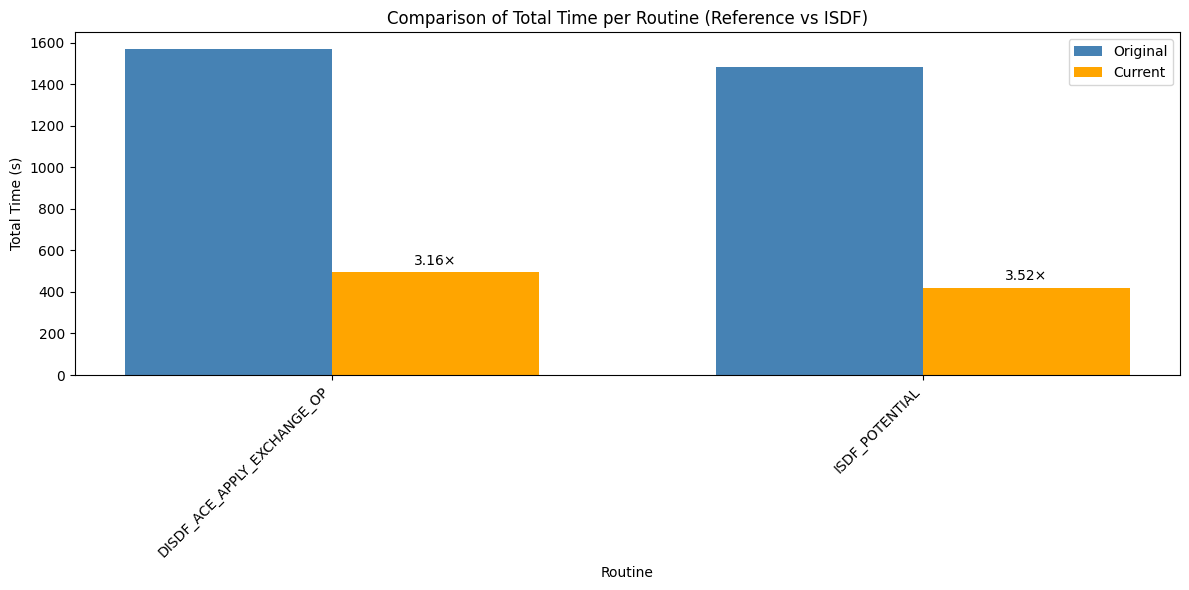

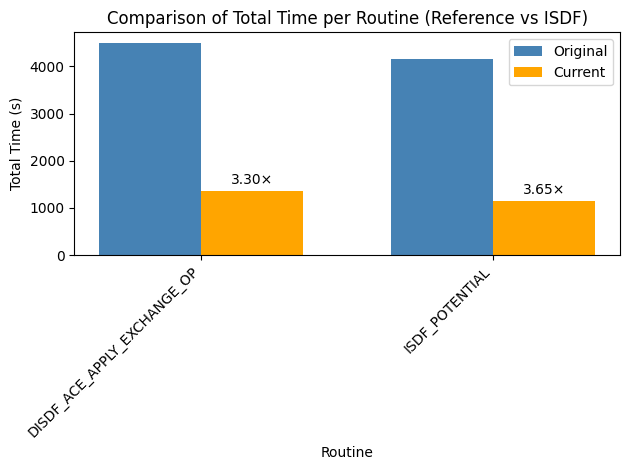

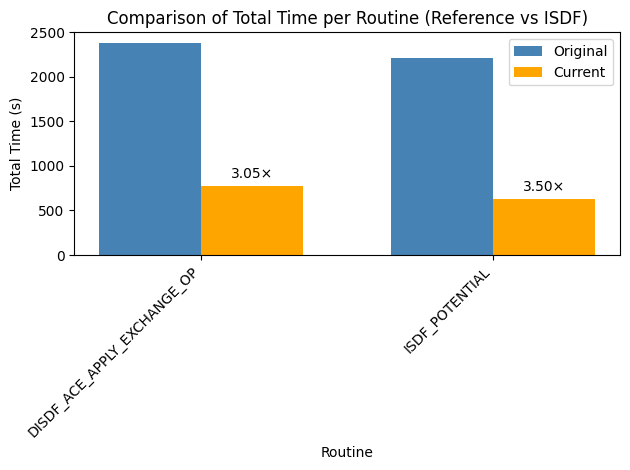

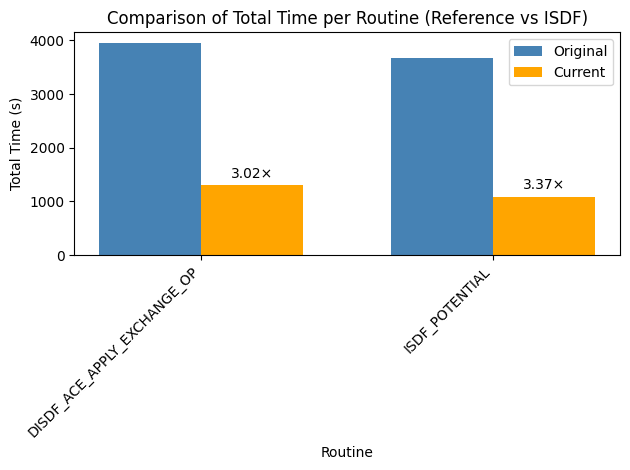

In [10]:
""" Comparison of original implementation vs improved implementation
"""
import numpy as np
import matplotlib.pyplot as plt

# Parse
original_root = Path("/home/bucchera/exchange_calcs/isdf")
current_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")

directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

original_isdf_results = {}
current_isdf_results = {}

for dir in directories:
    # Only keep cumulative times
    original_isdf_results[dir], _ = parse_time(original_root / dir / "profiling/time.000000")
    current_isdf_results[dir], _ = parse_time(current_root / dir / "profiling/time.000000")


# Plot
expensive_routines = ['DISDF_ACE_APPLY_EXCHANGE_OP', 'ISDF_POTENTIAL']

# Create x-axis positions
x = np.arange(len(expensive_routines))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))

for dir in directories:
    y1 = [original_isdf_results[dir][name]['TOTAL_TIME'] for name in expensive_routines]
    y2 = [current_isdf_results[dir][name]['TOTAL_TIME'] for name in expensive_routines]
    speedups = np.array(y1) / np.array(y2)

    bars1= plt.bar(x - width/2, y1, width, label="Original", color="steelblue")
    bars2 = plt.bar(x + width/2, y2, width, label="Current", color="orange")
    plt.gca().bar_label(bars2, labels=[f"{s:.2f}×" for s in speedups], padding=3)

    plt.xlabel("Routine")
    plt.ylabel("Total Time (s)")
    plt.title("Comparison of Total Time per Routine (Reference vs ISDF)")
    plt.xticks(x, expensive_routines, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
     


## Average SCF Time as a Function of Number of Occupied States

In [2]:
""" Parse average SCF time as a function of Number of occupied states
"""
from typing import List
from pathlib import Path

from isdfbenchmarks.parser import stdout

nocc = {'24_anthracene': 33, '30_tetracene': 42, '36_pentacene': 51, '42_ether_crown': 54}

# All single node jobs. 4 MPI, 8 OMP per process
molecules = ['24_anthracene', '30_tetracene', '36_pentacene', '42_ether_crown']

# Note, these will use more than one node. Either need to normalise OR run the above with more nodes
# For the sake of comparison to reference implementation, it's reasonable to normalise
to_run = ['60_buckminster', '73_chlorophyll', '84_c84']

# Parse SCF per time step
isdf_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
lower_precision_isdf_root = Path("/home/bucchera/exchange_calcs/lower_p_isdf")
onekmeans_isdf_root = Path("/home/bucchera/exchange_calcs/single_kmeans_isdf")


# Note, I need to change this to my repeat set of references, to CONFIRM that I have
# used consistent builds for reference and ISDF
ref_root = Path("/home/bucchera/exchange_calcs/reference_ace")

def parse_scf_times(root: Path, molecules: List[str]) -> dict:
    scf = {}
    for molecule in molecules:
        file = root / molecule / 'terminal.out'
        with open(file, mode='r') as fid:
            lines = fid.read()
        scf[molecule] = stdout.parse_scf_time(lines)
    return scf

ref_scf = parse_scf_times(ref_root, molecules)
isdf_scf = parse_scf_times(isdf_root, molecules)
lowp_isdf_scf = parse_scf_times(lower_precision_isdf_root, molecules)
onekm_isdf_scf = parse_scf_times(onekmeans_isdf_root, molecules)



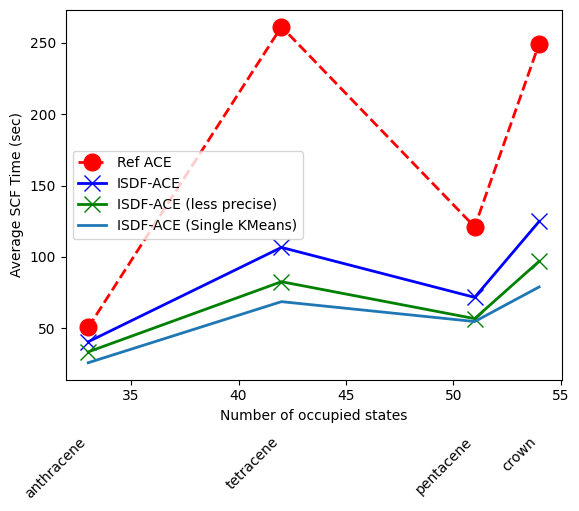

36_pentacene has not changed because I have gone back to more interpolation points
For precision ISDF (high number of vectors, time (s) per SCF cycle
24_anthracene [65.52, 45.78, 42.33, 40.99, 39.45, 39.28, 39.59, 38.04, 39.08, 39.44, 39.07, 38.37, 38.32, 38.33, 38.2, 38.46, 38.11, 38.05, 38.83, 37.66, 37.38]
30_tetracene [208.25, 111.05, 126.27, 111.05, 121.94, 129.31, 103.82, 103.49, 100.73, 102.27, 99.94, 103.57, 101.8, 97.32, 101.55, 97.98, 96.27, 99.27, 94.46, 96.59, 96.59, 93.21, 93.68, 94.0, 94.5, 93.39]
36_pentacene [133.8, 77.48, 71.48, 70.51, 77.47, 75.22, 70.16, 66.06, 69.76, 63.71, 70.99, 67.82, 67.23, 63.58, 63.49, 65.32, 63.75, 65.73, 63.41, 65.37]
42_ether_crown [199.58, 138.37, 130.79, 124.73, 124.49, 124.3, 121.16, 118.31, 125.43, 122.03, 119.91, 116.34, 115.32, 116.01, 116.19, 115.89, 116.26, 115.19, 111.32]


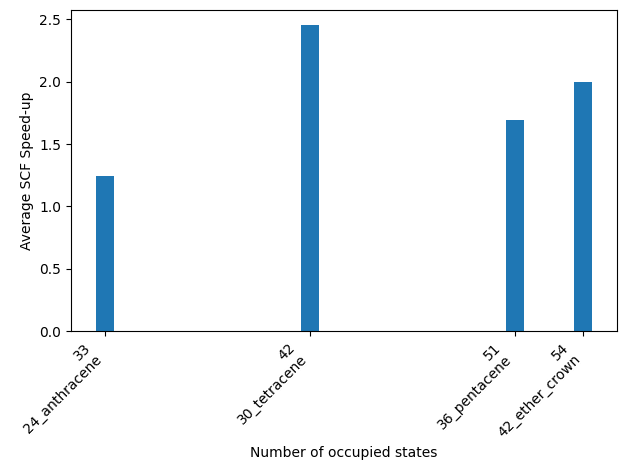

Expected scaling shown, attached to every peak
For the faster ISDF calculation using less interpolation vectors


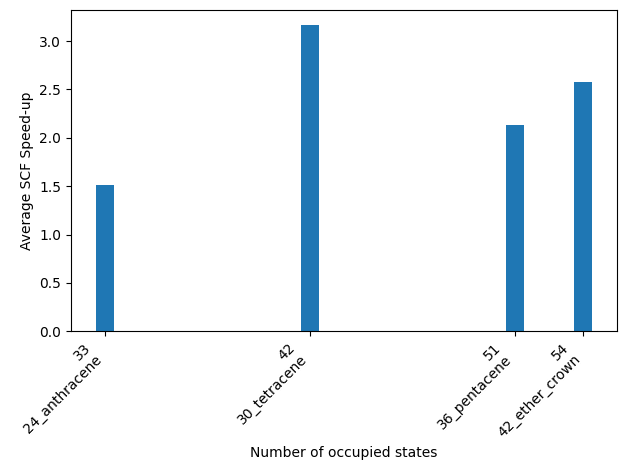

Expected scaling shown, attached to every peak
For the faster ISDF calculation using less interpolation vectors


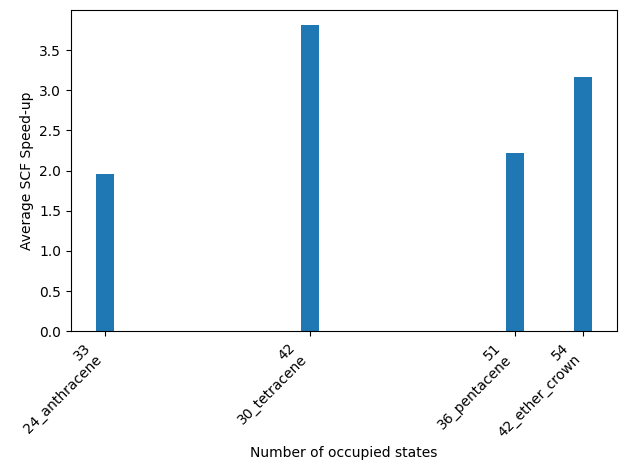

Expected scaling shown, attached to every peak


In [7]:
""" Plot average SCF time as a function of Number of occupied states
"""
import numpy as np
import matplotlib.pyplot as plt


# Average SCF time as a function of number of occupied states
n_molecules = len(list(nocc))
avg_scf = np.empty(shape=(4, n_molecules))

assert list(ref_scf) == list(isdf_scf), "SCF times must be for a consistent set of molecules"

# Occupied states
occupied = [iocc for iocc in nocc.values()]

# Times
i = 0
for key, times in ref_scf.items():
    avg_scf[0, i] = np.mean([time for time in times.values()])
    avg_scf[1, i] = np.mean([time for time in isdf_scf[key].values()])
    avg_scf[2, i] = np.mean([time for time in lowp_isdf_scf[key].values()])
    avg_scf[3, i] = np.mean([time for time in onekm_isdf_scf[key].values()])
    i += 1
    
plt.plot(occupied, avg_scf[0, :], 'ro--', linewidth=2, markersize=12, label="Ref ACE")
plt.plot(occupied, avg_scf[1, :], 'bx-', linewidth=2, markersize=12, label="ISDF-ACE")
plt.plot(occupied, avg_scf[2, :], 'gx-', linewidth=2, markersize=12, label="ISDF-ACE (less precise)")
plt.plot(occupied, avg_scf[3, :], linewidth=2, markersize=12, label="ISDF-ACE (Single KMeans)")


plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Time (sec)")

for key, xpos in nocc.items():
    label = key.split('_')[-1]
    plt.text(xpos, plt.ylim()[0] - 0.15*(plt.ylim()[1]-plt.ylim()[0]),
             label, ha='right', va='top', rotation=45)

plt.legend()
plt.show()
print("36_pentacene has not changed because I have gone back to more interpolation points")


# Same plot, but ignoring the first SCF iteration
print("For precision ISDF (high number of vectors, time (s) per SCF cycle")
for key, times in ref_scf.items():
    a = [time for time in isdf_scf[key].values()]
    print(key, a)


# Average speed-up per SCF iteration 
speedup = avg_scf[0, :] / avg_scf[1, :]

# Number of interpolation points
n_interp = np.array([565.0, 447.0, 707.0, 724.0])

# Expected scaling agrees extremely closely with what I get if I include a factor
# reduction for the (ij) = (ji) pair symmmetry, which the reference can exploit but ISDF cannot
ij_symmetry = 0.5
expected_scaling = ij_symmetry * np.asarray(occupied)**2 / (0.75 * n_interp)

bars = plt.bar(occupied, speedup)
plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Speed-up")
plt.xticks(occupied, [f"{n}\n{mol}" for n, mol in zip(occupied, molecules)], rotation=45, ha='right')
# plt.gca().bar_label(bars, labels=[f"{s:.2f}×" for s in expected_scaling], padding=3)
plt.tight_layout()
plt.show()

print("Expected scaling shown, attached to every peak")


# Repeat for the faster calculation
print("For the faster ISDF calculation using less interpolation vectors")

# Average speed-up per SCF iteration 
speedup = avg_scf[0, :] / avg_scf[2, :]

# Number of interpolation points
n_interp = np.array([424.0, 335.0, 530.0, 543.0])

# Expected scaling agrees extremely closely with what I get if I include a factor
# reduction for the (ij) = (ji) pair symmmetry, which the reference can exploit but ISDF cannot
ij_symmetry = 0.5
expected_scaling = ij_symmetry * np.asarray(occupied)**2 / (0.75 * n_interp)

bars = plt.bar(occupied, speedup)
plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Speed-up")
plt.xticks(occupied, [f"{n}\n{mol}" for n, mol in zip(occupied, molecules)], rotation=45, ha='right')
# plt.gca().bar_label(bars, labels=[f"{s:.2f}×" for s in expected_scaling], padding=3)
plt.tight_layout()
plt.show()

print("Expected scaling shown, attached to every peak")



# Repeat for the single-kmeans calculation
print("For the faster ISDF calculation using less interpolation vectors")

# Average speed-up per SCF iteration 
speedup = avg_scf[0, :] / avg_scf[3, :]

# Number of interpolation points
n_interp = np.array([424.0, 335.0, 707.0, 543.0])

# Expected scaling agrees extremely closely with what I get if I include a factor
# reduction for the (ij) = (ji) pair symmmetry, which the reference can exploit but ISDF cannot
ij_symmetry = 0.5
expected_scaling = ij_symmetry * np.asarray(occupied)**2 / (0.75 * n_interp)

bars = plt.bar(occupied, speedup)
plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Speed-up")
plt.xticks(occupied, [f"{n}\n{mol}" for n, mol in zip(occupied, molecules)], rotation=45, ha='right')
# plt.gca().bar_label(bars, labels=[f"{s:.2f}×" for s in expected_scaling], padding=3)
plt.tight_layout()
plt.show()

print("Expected scaling shown, attached to every peak")


In [30]:
"""Effect of lowering the number of ISDF vectors on the Error in Exact Exchange
"""
from pathlib import Path

from isdfbenchmarks.parser import static


ref_root = Path("/home/bucchera/exchange_calcs/reference_ace")
isdf_root = Path("/home/bucchera/exchange_calcs/mpi_isdf")
lower_precision_isdf_root = Path("/home/bucchera/exchange_calcs/lower_p_isdf")

# All single node jobs. 4 MPI, 8 OMP per process
nocc = {'24_anthracene': 33, '30_tetracene': 42, '36_pentacene': 51, '42_ether_crown': 54}
n_atoms = {key:float(key.split('_')[0]) for key in nocc.keys()}
molecules = list(nocc)

exx_result = {}
for molecule in molecules:
    ref_exx = static.info_file(ref_root / molecule)['Energy']['Exchange']
    isdf_exx = static.info_file(isdf_root / molecule)['Energy']['Exchange']
    lowp_isdf_exx = static.info_file(lower_precision_isdf_root / molecule)['Energy']['Exchange']
    exx_result[molecule] = [(isdf_exx - ref_exx) / n_atoms[molecule], (lowp_isdf_exx - ref_exx) / n_atoms[molecule]]

print("Molecule | Error using optimal Nisdf (Ha/atom) | Error using less Nisdf (Ha/atom)")
for molecule, exx in exx_result.items():
    print(molecule, exx[0], exx[1])


comment = """
Note, I had not looked at the errors except for in anthracene, which is extremely well-converged.
These results imply that despite using the ank of the Gram matrix, CC^T, which clearly works, that the sets of chosen
points are not necessarily optimal, and in the case of tetracene, clearly quite far from optimal.

* Need to improve how the initial points are selected, and the quality of KMeans.
"""

print(comment)

Molecule | Error using optimal Nisdf (Ha/atom) | Error using less Nisdf (Ha/atom)
24_anthracene 3.9166666650676994e-08 9.708333333543114e-08
30_tetracene 1.0186666666633925e-06 1.595233333334297e-05
36_pentacene 2.2333333333297074e-07 4.083055555560557e-06
42_ether_crown 1.1904761916999481e-08 3.830952381143166e-07

Note, I had not looked at the errors except for in anthracene, which is extremely well-converged.
These results imply that despite using the ank of the Gram matrix, CC^T, which clearly works, that the sets of chosen
points are not necessarily optimal, and in the case of tetracene, clearly quite far from optimal

* Need to improve how the initial points are selected, and the quality of KMeans.


# Timing as a function of MPI processes for anthracene

## TODOs
* Run ISDF for 2 and 3 processes
* Run ref for 2 and 3 processes

# Convergence in Exact Exchange Energy as a Function of ISDF Vectors

* Single MPI process, but using threads
* Anthracene



In [37]:
""" Convergence in EXX w.r.t. number of ISDF vectors
"""
# Reference
root = Path("/home/bucchera/exchange_calcs/compare_anthracene")

with open(root / "ref_np1/terminal.out", mode='r') as fid:
    lines = fid.read()
ref_exx: dict = stdout.parse_exchange_energy(lines)

# ISDF
calculations = ['isdf_np1_250points', 'isdf_np1_350points', 'isdf_np1_450points', 'isdf_np1_565points']
isdf_vectors = ['250', '350', '450', '565']

isdf_exx = {}
for vector, folder in zip(isdf_vectors, calculations):
    file = root / folder / 'terminal.out'
    with open(file, mode='r') as fid:
        lines = fid.read()
    isdf_exx[vector] = stdout.parse_exchange_energy(lines)


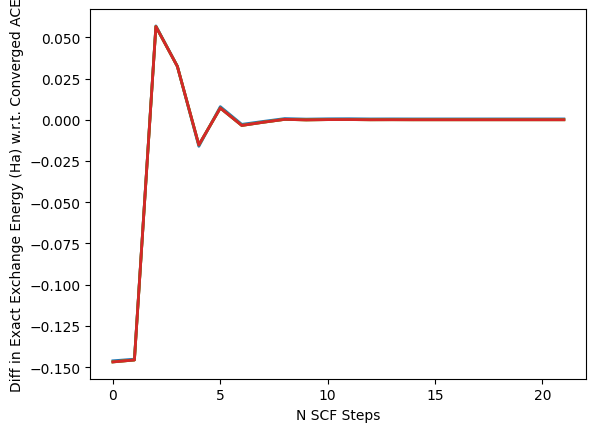

In [48]:
""" Plot data
"""
# Converged ACE EXX energy
ref_energy = [e for e in ref_exx.values()][-1]

for vector, isdf_data in isdf_exx.items():
    energies = np.asarray([e for e in isdf_data.values()]) - ref_energy
    plt.plot(list(isdf_data), energies, linewidth=2, markersize=8, label=str(vector))

plt.xlabel("N SCF Steps")
plt.ylabel("Diff in Exact Exchange Energy (Ha) w.r.t. Converged ACE")
plt.show()

N ISDF Vectors, Error in EXX (Ha)
250 0.0004866352097661064
350 1.4025429311281812e-05
450 1.1486849542663435e-06
565 9.510807901236262e-07


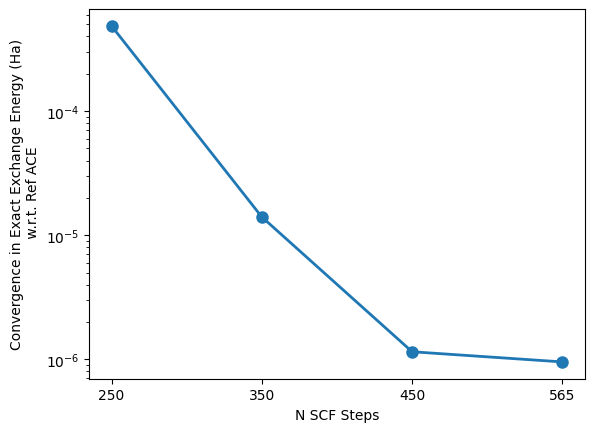

In [49]:
# Energy scale makes the above plot pointless, so plot the convergence in the SCF-converged 
# EXX relative to the ACE reference, as a function of the number of ISDF vectors

print("N ISDF Vectors, Error in EXX (Ha)")
converged_energies = []
for vector, isdf_data in isdf_exx.items():
    converged_isdf_energy = np.asarray([e for e in isdf_data.values()])[-1]
    error = converged_isdf_energy - ref_energy
    converged_energies.append(converged_isdf_energy - ref_energy)  
    print(vector, error)

plt.plot(isdf_vectors, converged_energies, 'o-', linewidth=2, markersize=8)
plt.yscale("log")
plt.xlabel("N SCF Steps")
plt.ylabel("Convergence in Exact Exchange Energy (Ha)\n w.r.t. Ref ACE")
plt.show()
